In [1]:
%pwd

'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\notebooks'

In [2]:
%cd ..

C:\Users\Peter\PycharmProjects\olfaction_evolution


In [3]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tools
from pylab import *
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
import os
import glob
import standard.analysis as sa
import tools
import matplotlib.pyplot as plt
import task
import tensorflow as tf
from model import FullModel
from dict_methods import *

%matplotlib inline

C:\Users\Peter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['image.cmap']='jet'

In [42]:
d = r'C:\Users\Peter\PycharmProjects\olfaction_evolution\files\cluster_simple'

In [43]:
files = glob.glob(os.path.join(d,'cluster_simple50'))
res = defaultdict(list)
for f in files:
    temp = tools.load_all_results(f, argLast = False)
    chain_defaultdicts(res, temp)

['C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000000', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000001', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000002', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000003', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000004', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000005', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000006', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000007', 'C:\\Users\\Peter\\PycharmProjects\\olfaction_evolution\\files\\cluster_simple\\cluster_simple50\\000008', 'C:\\Users\\Peter\\PycharmProjects\\

C:\Users\Peter\PycharmProjects\olfaction_evolution\tools.py:232: RuntimeWarning: divide by zero encountered in log
  res['train_logloss'] = np.log(res['train_loss'])


(0, 10000)

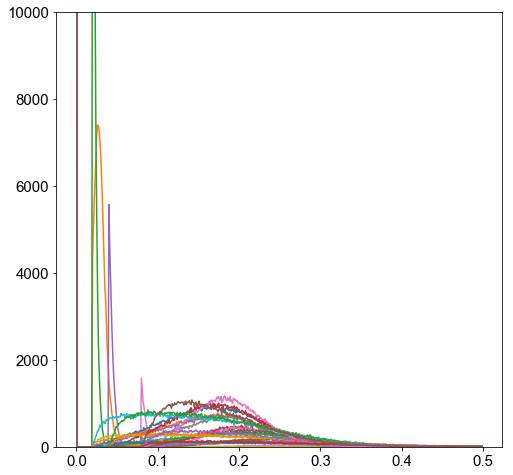

In [44]:
plt.figure(figsize=(8,8))
plt.plot(res['lin_bins'][0,:500],res['lin_hist'][:,-1,:500].T)
plt.ylim([0, 10000])

In [45]:
peak_inds = np.zeros_like(res['kc_prune_threshold']).astype(np.bool)
for i, thres in enumerate(res['kc_prune_threshold']):
    x = np.where(res['lin_bins'][i,:-1] > res['kc_prune_threshold'][i])[0][0]
    if res['lin_hist'][i,-1,x] > 1000:
        peak_inds[i] = False
    else:
        peak_inds[i] = True
peak_inds    

array([ True, False, False,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [46]:
res['lr'][np.invert(peak_inds)]

array([0.003, 0.003, 0.003, 0.003])

(0, 5000)

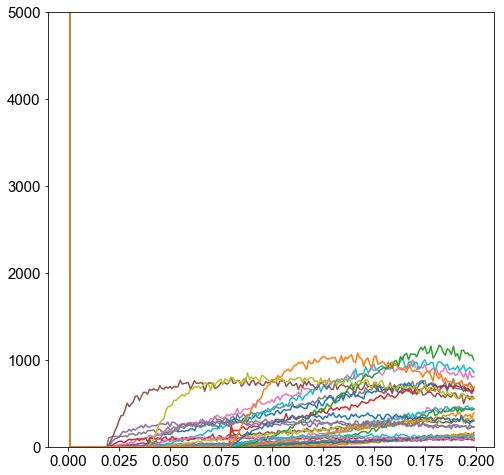

In [49]:
plt.figure(figsize=(8,8))
plt.plot(res['lin_bins'][0,:200],res['lin_hist'][np.where(peak_inds)[0],-1,:200].T)
plt.ylim([0, 5000])

(0, 10000)

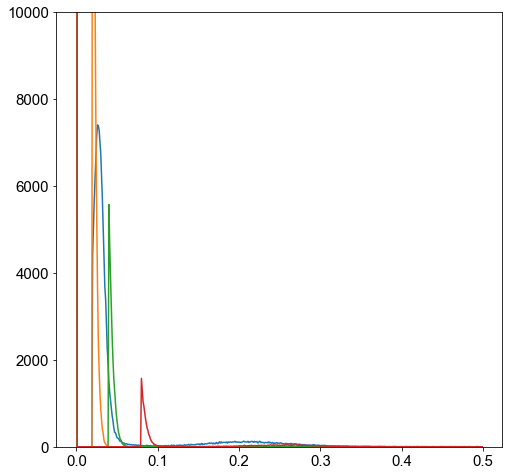

In [50]:
plt.figure(figsize=(8,8))
plt.plot(res['lin_bins'][0,:500],res['lin_hist'][np.invert(peak_inds),-1,:500].T)
plt.ylim([0, 10000])

In [54]:
acc_ind = res['train_acc'][:,-1] > .75
res['lr'][np.invert(acc_ind)]

array([0.003 , 0.003 , 0.003 , 0.003 , 0.003 , 0.003 , 0.003 , 0.003 ,
       0.003 , 0.001 , 0.001 , 0.0003, 0.0003, 0.0003, 0.0001, 0.0001])

In [56]:
badkc_ind = res['bad_KC'][:,-1] < .2
res['separate_lr'][np.invert(badkc_ind)]

array([0.001, 0.001, 0.001, 0.001, 0.001])

In [57]:
ind = np.logical_and(badkc_ind, acc_ind, peak_inds)
res['separate_lr'][ind]

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001])

In [58]:
#filter
for k, v in res.items():
    res[k] = v[peak_inds]

In [59]:
def _get_K(res):
    n_model, n_epoch = res['sparsity'].shape[:2]
    Ks = np.zeros((n_model, n_epoch))
    bad_KC = np.zeros((n_model, n_epoch))
    for i in range(n_model):
        for j in range(n_epoch):
            sparsity = res['sparsity'][i, j]
            Ks[i, j] = sparsity[sparsity>0].mean()
            bad_KC[i,j] = np.sum(sparsity==0)/sparsity.size
    res['K'] = Ks
    res['bad_KC'] = bad_KC

In [60]:
_get_K(res)

In [61]:
def simple_plot(xkey, ykey, filter_dict = None):
    if filter_dict is not None:
        temp = filter.filter(res, filter_dict=filter_dict)
    
    x = res[xkey]
    y = res[ykey][:,-1]
    plt.figure()
    plt.plot(np.log(x), y, '*')
    plt.xticks(np.log(x),x)
    plt.xlabel(xkey)
    plt.ylabel(ykey)
    
    if filter_dict is not None:
        plt.legend('{} = {}'.format(filter_dict.key,value))

In [62]:
def marginal_plot(xkey, ykey, vary_key, marginals=None):
    plt.figure()
    for i in np.unique(res[vary_key]):
        temp = filter(res, {vary_key:i})
        if marginals:
            temp = filter(temp, marginals)
        x = temp[xkey]
        y = temp[ykey][:,-1]

        plt.plot(np.log(x), y, '*')
    x = np.unique(res[xkey])
    plt.xticks(np.log(x),x)
    plt.xlabel(xkey)
    plt.ylabel(ykey)
    plt.legend(np.unique(res[vary_key]))
    plt.title(marginals)

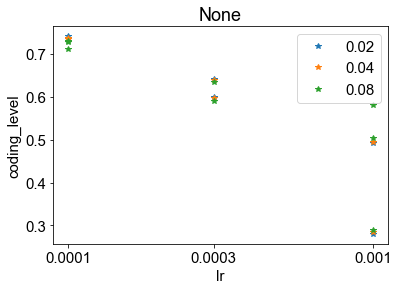

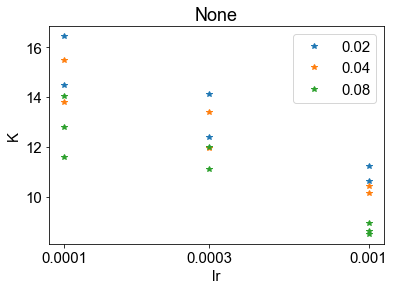

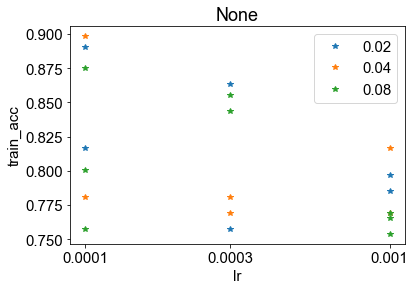

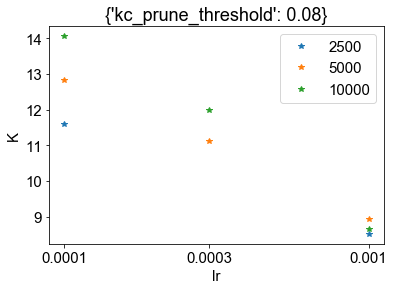

In [65]:
marginal_plot('lr', 'coding_level', 'kc_prune_threshold')
marginal_plot('lr', 'K', 'kc_prune_threshold')
marginal_plot('lr', 'train_acc', 'kc_prune_threshold')
marginal_plot('lr', 'K', 'N_KC', {'kc_prune_threshold':0.08})

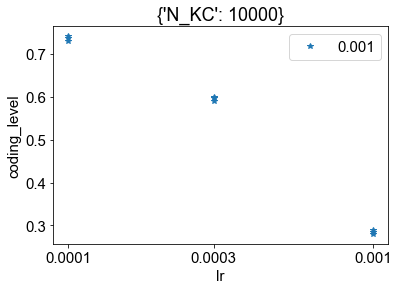

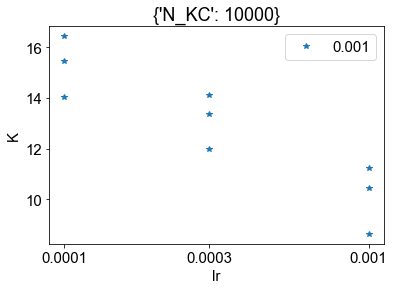

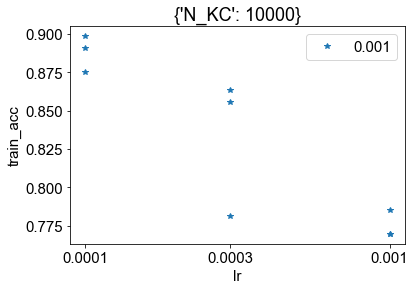

In [37]:
marginal_plot('lr', 'coding_level', 'separate_lr', {'N_KC':10000})
marginal_plot('lr', 'K', 'separate_lr', {'N_KC':10000})
marginal_plot('lr', 'train_acc', 'separate_lr', {'N_KC':10000})

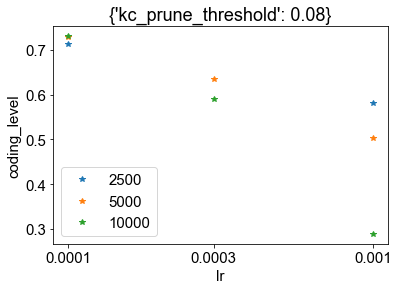

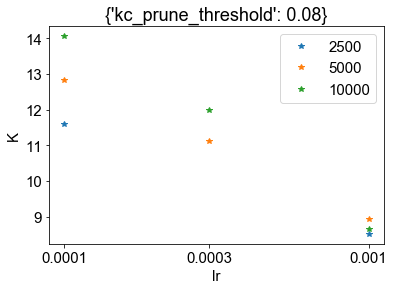

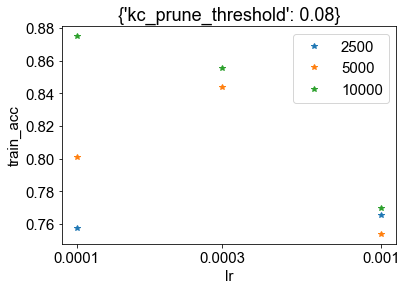

In [66]:
marginal_plot('lr', 'coding_level', 'N_KC', {'kc_prune_threshold':0.08})
marginal_plot('lr', 'K', 'N_KC', {'kc_prune_threshold':0.08})
marginal_plot('lr', 'train_acc', 'N_KC', {'kc_prune_threshold':0.08})

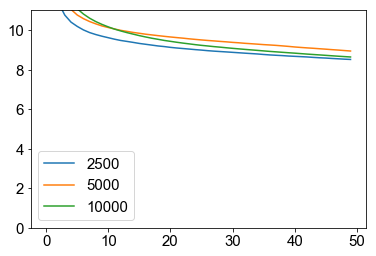

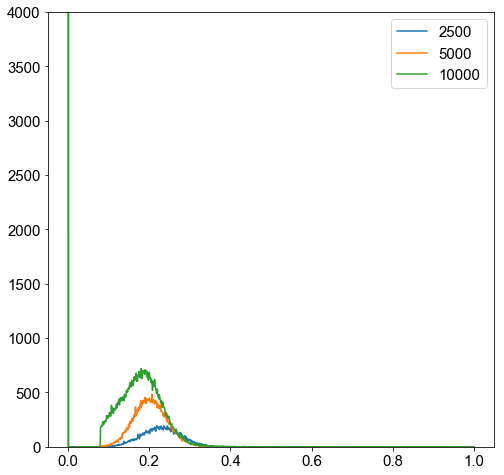

In [75]:
x = filter(res, {'kc_prune_threshold':0.08, 'lr':0.001})
plt.plot(x['K'].T)
plt.legend(np.unique(x['N_KC']))
plt.ylim([0, 11])

plt.figure(figsize=(8,8))
plt.plot(x['lin_bins'][0,:-1],x['lin_hist'][:,-1].T)
plt.ylim([0, 4000])
plt.legend(np.unique(x['N_KC']))

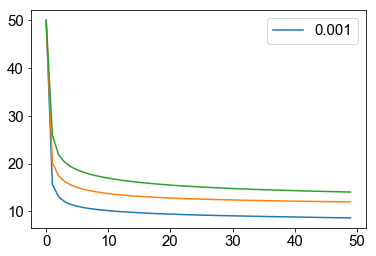

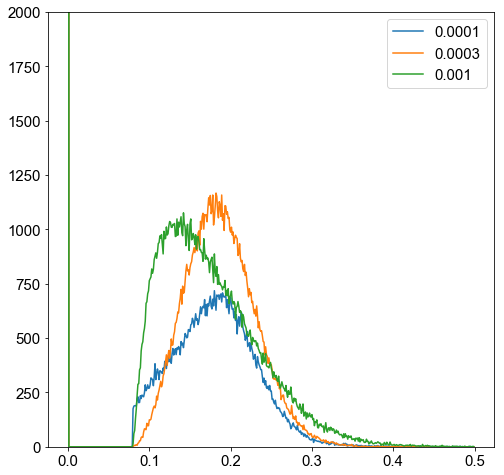

In [73]:
x = filter(res, {'separate_lr':0.001, 'N_KC':10000, 'kc_prune_threshold':0.08})
plt.plot(x['K'].T)
plt.legend(np.unique(x['separate_lr']))

plt.figure(figsize=(8,8))
plt.plot(x['lin_bins'][0,:500],x['lin_hist'][:,-1,:500].T)
plt.ylim([0, 2000])
plt.legend(np.unique(x['lr']))